<a href="https://colab.research.google.com/github/kfahn22/Colab_notebooks/blob/main/colormap_labeled_image_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generating a Simple Labeled Dataset

In this notebook, we are going to demo how to create a toy dataset of labeled  cellular automaton images.

[Cellular Automaton](https://mathworld.wolfram.com/ElementaryCellularAutomaton.html) were described by Stephen Wolphram in [A New Kind of Science](https://www.wolframscience.com/nks/).  Imagine you have a grid, like a checkerboard. Each square in the grid has a state - either on or off, with the state of the square determining its color. There are rulesets (256 of them) that describe how the squares change their state depending on what's happening around them.  Here is a list of all the [rulesets](https://plato.stanford.edu/entries/cellular-automata/supplement.html).

[CellPyLib](https://github.com/lantunes/cellpylib) is a python library for working with Cellular Automata. We will use it to generate the labeled images.




Run this cell if you have generated a large dataset. It is unnecessary for this toy example.

In [ ]:
!apt-get install git-lfs

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.


First, let's install the dependencies.

In [ ]:
!pip install cellpylib huggingface_hub datasets

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.1 MB/s eta 0:00:00
  Created wheel for cellpylib: filename=cellpylib-2.4.0-py3-none-any.whl size=37921 sha256=c7b8a7a5798b08078b89f84ef3a353b42b598dc168d4a26ed0200fbfaea8ac69
  Stored in directory: /root/.cache/pip/wheels/44/bc/c4/4730d328071b164c25d392c2d932b513e56ff0857da63d17e7
Successfully built cellpylib


Let's log into the Hugging Face Hub with our WRITE access token.

In [ ]:
from huggingface_hub import notebook_login

notebook_login()


The CellPyLib library uses [Matplotlib](https://matplotlib.org/) to plot the images. We can add color to the images by specifying the [colormap](https://matplotlib.org/stable/users/explain/colors/colormaps.html). We will write a couple of helper functions to create custom colormaps.  The first one creates a custom colormap from two colors. The second creates a colormap from two random colors. For ease, we will use the random colormap to render the images.

We will write a function to create a custom colormap.  

In [ ]:
# Define new colormap
import matplotlib.pyplot as plt
import numpy as np

#import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap

def custom_colormap(color1, color2, n_bins):
    """Return a LinearSegmentedColormap
    color1 and color2 are the two colors that are interpolated between
    color1: a dictionary with the color name and rgb values
    color2: a dictionary with the color name and rgb values
    n_bins: Discretizes the interpolation into bins
    """
    col1 = color1['rgb']
    col2 = color2['rgb']
    colors = [col1, col2]
    name1 = color1['color_name']
    name2 = color2['color_name']
    cmap_name = name1 + '/' + name2
    for n_bin in range(n_bins):
      cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bin)
    return cmap, cmap_name

color1 = {"color_name": "salmon_pink", "rgb": np.array([239,149,156]) / 255}
color2 = {"color_name": "cadet_grey", "rgb": np.array([141, 161, 185]) / 255}

cmap = custom_colormap(color1, color2, 10)

We will next define a function to create a custom colormap out of two random CSS4 colors.  You can learn more about the named colors [here](https://matplotlib.org/stable/gallery/color/named_colors.html)

In [ ]:
import random
import matplotlib.colors as mcolors

# Define new colormap
import matplotlib.pyplot as plt
import numpy as np

#import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap

def make_colormap(n_bins):
    """Return a LinearSegmentedColormap
    color1 and color2 are the two colors that are interpolated between
    n_bins: Discretizes the interpolation into bins
    """
    colors = mcolors.CSS4_COLORS
    color_name1 = random.choice(list(colors.keys()))
    color_name2 = random.choice(list(colors.keys()))
    color1 = colors[color_name1]
    color2 = colors[color_name2]
    cmap_name = color_name1 + '/' + color_name2
    color_choices = [color1, color2]
    for n_bin in range(n_bins):
      cmap = LinearSegmentedColormap.from_list(cmap_name, color_choices, N=n_bin)
    return cmap, color_name1, color_name2

We will add the images to a "generated_images" folder and then load this folder to the Hugging Face Hub.

In [ ]:
import os
generated_images_dir = "/content/generated_images"
os.makedirs(generated_images_dir, exist_ok=True)

Now we will add a function to write a metadata.jsonl file.  This dictionary will contain the filename (the key *must* named be "file_name") and associated text label.

In [ ]:
# Create a metadata_file
def metadata_file(filename, label, output_path):
    with open(output_path, 'a') as file:

            # Create a dictionary with file and text label
            metadata_entry = {"file_name": filename, 'text': label}

            # Write the entry to the file as a JSON line
            file.write(json.dumps(metadata_entry) + '\n')

This next cell defines a function to create the celluar automata.

In [ ]:
def init_automata(ruleset, cells):
      # we input the number of cells, which will determine the resolution of the image
      # we will use a square aspect ratio, but you can adjust height by changing timesteps to a different number
      ca = cpl.init_simple(cells)
      # Initialize the cellular automata with a random initial ruleset
      ca = cpl.evolve(ca, timesteps=cells, memoize=True,
                                      apply_rule=lambda n, c, t: cpl.nks_rule(n, ruleset))
      return ca

We will write a function to add a label to the image.

In [ ]:
# Function to add label to image based on random ruleset and colormap
def label_automata(ruleset, col):
    return f'a {col} cellular automata with ruleset {ruleset}'

The default size of the grid in Matplotlib is small, so we will write a utility function to rescale the image using the PIL library.

In [ ]:
# Add a function to rescale the images
def rescale_image(image_path, scale_factor):
    image = Image.open(image_path)
    width = int(image.width * scale_factor)
    height = int(image.height * scale_factor)
    upscaled_image = image.resize((width, height), resample=Resampling.LANCZOS)
    upscaled_image.save(image_path)

We now have all of the pieces in place to add the images to our dataset.  

  0%|          | 0/1000 [00:00<?, ?it/s]

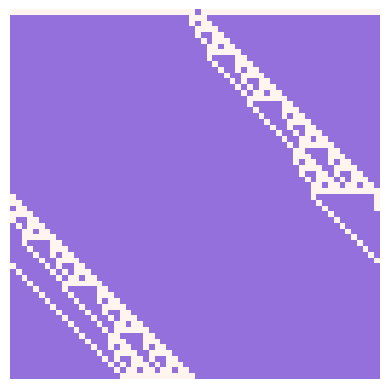

In [ ]:
import random
import numpy as np
import cellpylib as cpl
import matplotlib.pyplot as plt
from PIL import Image
from PIL.Image import Resampling
import json
from tqdm.auto import tqdm

# Rulesets are 0 through 255
ruleset = random.randint(0, 255)
# Original resolution of image
cells = 64

# Specify the number of images to generate
num_images_to_generate = 1000

# Specify the output file path for metadata.jsonl file
output = 'generated_images/metadata.jsonl'

def add_image(idx, ruleset, cmap, colors):
      # Initialize the cellular automata with a random initial state
      ca = init_automata(ruleset, cells)

      # Since we are only interested in the image, we turn off the axis
      plt.axis('off')

      # Set the colormap
      plt.set_cmap(cmap)
      # Save the image to the generated_images folder
      path = f'generated_images/{idx}.png'
      # Save the image
      plt.imsave(path, ca, cmap=cmap)
      rescale_image(path, 2)

      # Display the image
      plt.imshow(ca, cmap=cmap)

      # Our metadata.jsonl file takes a filename and label
      # Generate a filename for the image
      filename = f'{idx}.png'
      # Generate a label for the image
      label = label_automata(ruleset, colors)

      # Write the metadata.jsonl file
      metadata_file(filename, label, output)

# Add images to dataset
for i in tqdm(range(num_images_to_generate)):
    ruleset = random.randint(0, 255)
    # Generate a random colormap
    colormap = make_colormap(4)
    # Extract the colormap and the two colors
    cmap = colormap[0]
    c1 = colormap[1]
    c2 = colormap[2]
    colors = f'{c1} and {c2}'
    add_image(i, ruleset, cmap, colors)

We are now ready to load the generated images and upload them to the Hugging Face Hub. You can read more about uploading an image dataset to the Hugging Face Hub [here](https://huggingface.co/docs/datasets/image_dataset).

In [ ]:
from datasets import load_dataset
dataset = load_dataset("imagefolder", data_dir="generated_images")

Resolving data files:   0%|          | 0/1001 [00:00<?, ?it/s]

In [ ]:
user_name = "kfahn"
repo_name = "cellular_automata"

In [ ]:
dataset.push_to_hub(f"{user_name}/{repo_name}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/10 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/kfahn/cellular_automata/commit/24a4b4d38e9e60a882b2cf3b007e72ec24dc4f60', commit_message='Upload dataset', commit_description='', oid='24a4b4d38e9e60a882b2cf3b007e72ec24dc4f60', pr_url=None, pr_revision=None, pr_num=None)

If desired, we can do a test download of our new labeled image dataset.

In [ ]:
from datasets import load_dataset
dataset = load_dataset("kfahn/cellular_automata")


Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Let's take a look at one of the downloaded images.

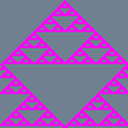

In [ ]:
dataset['train'][0]['image']

Now let's look at the label.

In [ ]:
dataset['train'][0]['text']

'a slategrey and magenta cellular automata with ruleset 126'